# Machine Learning - Project

In [198]:
%pip install category-encoders
%pip install imbalanced-learn
%pip install matplotlib
%pip install pandas
%pip install scikit-learn
%pip install seaborn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -

# Introduction

In the context of the Machine Learning laboratory, we will work with [Xente Fraud Detection Challenge](https://zindi.africa/competitions/xente-fraud-detection-challenge).

The purpose is to create a Machine Learning model that is able to predict if a transaction is a fraud.

For that, we will go through several steps:

 * Features Engineering: Capacity to extract the most useful information from raw data
 * Model definition
 * Prediction
 * Submission of our result

To train the model, we have the [training dataset](./data/training.csv) and the [test dataset](./data/test.csv) to submit our results.

# Columns Definitions

Here is the meaning of every columns explain in [Xente_Variable_Definitions.csv](./data/Xente_Variable_Definitions.csv).

 * **TransactionId**: Unique transaction identifier on platform
 * **BatchId**: Unique number assigned to a batch of transactions for processing
 * **AccountId**: Unique number identifying the customer on platform
 * **SubscriptionId**: Unique number identifying the customer subscription
 * **CustomerId**: Unique identifier attached to Account
 * **CurrencyCode**: Country currency
 * **CountryCode**: Numerical geographical code of country
 * **ProviderId**: Source provider of Item bought.
 * **ProductId**: Item name being bought.
 * **ProductCategory**: ProductIds are organized into these broader product categories.
 * **ChannelId**: Identifies if customer used web,Android, IOS, pay later or checkout.
 * **Amount**: Value of the transaction. Positive for debits from customer account and negative for credit into customer account
 * **Value**: Absolute value of the amount
 * **TransactionStartTime**: Transaction start time
 * **PricingStrategy**: Category of Xente's pricing structure for merchants
 * **FraudResult**: Fraud status of transaction 1 -yes or 0-No


# Load training data

Let's load our training data from [training.csv](./data/training.csv).

We set `TransactionId` as the index of our training data.

In [199]:
training_data_path = './data/training.csv'

# Read data from file
training_data = pd.read_csv(training_data_path)

# Set the 'TransactionId' as index
training_data.set_index('TransactionId', inplace=True)

training_data.head(5)

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
TransactionId,,,,,,,,,,,,,,,
TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


# Features Engineering

Now that we have our data loaded, let's analyse the different data in order the get the best possible model.

## Drop useless features

The first thing that I do is to remove the `BatchId` column, because it just gives me the information about the batch of transaction for processing.

Also, I remove the features `CustomerId`, `AccountId` and `SubscriptionId` because they are relative to an account or a customer. In our case, we don't want to classify a fraud regarding a consumer or an account.

> Note: I use the relationship between `CustomerId` and `Value` later.

## Transaction country

First, we will attack with the columns `CurrencyCode` and `CountryCode`. Actually, they point to the same thing: in which country the transaction has been done. Thus, we can say that having both columns is redundant to estimate our model prediction.

We will first look at the occurrence of every country and then check its relationship with the target value.

In [200]:
# Load CurrencyCode and CountryCode
X_currency_code = training_data['CurrencyCode']
X_country_code = training_data['CountryCode']

# Count occurence of each rows
currency_code_occurences = X_currency_code.nunique()
country_code_occurences = X_country_code.nunique()

# Show information
print(f'Distinct CurrencyCode: {currency_code_occurences}')
print(f'Distinct CountryCode: {country_code_occurences}')

Distinct CurrencyCode: 1
Distinct CountryCode: 1


As we can see, `CurrencyCode` and `CountryCode` has only one distinct value in all the dataset. Give that, we can say that this column will not give any additional information to our model.

Based on the Mutual Information calculated above, we can see than `CurrencyCode` and `CountryCode` are independent variables. I will remove these features from the dataset.

## Transaction Start Time

As information, we have `TransactionStartTime` and it is the transaction start time. It is written using the [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) date format. In this form, we cannot exploit the data in our model.

From `TransactionStartTime`, we can take some interesting information such as:
 * Day of the week
 * Month
 * Hours of the day

By retrieving this information, we can try to visualise if the fraud is something periodically, that happens on certain week day, etc, ...

Given that, our first step will be to preprocessing our data and create 3 new columns: `TransactionWeekDay`, `TransactionMonth` and `TransactionHour`.

 * **TransactionWeekDay**: 0 - 6
 * **TransactionMonth**: 1 - 12
 * **TransactionHour**: 0 - 23

In [201]:
def apply_transaction_start_date(destination):
    # Convert every string in datetime object
    pd_datetime = pd.to_datetime(destination['TransactionStartTime'])
    pd_datetime_index = pd.DatetimeIndex(pd_datetime)

    # Retrieve month and week day
    destination['TransactionMonth'] = pd_datetime_index.month
    destination['TransactionHour'] = pd_datetime_index.hour
    destination['TransactionWeekDay'] = pd_datetime_index.weekday

    # Drop TransactionStartTime
    destination.drop(columns=['TransactionStartTime'], inplace=True)

    return destination

In [202]:
# Create DataFrame
transaction_start_time_details  = training_data.loc[:, ['TransactionStartTime']].copy()

# Convert string to usable start date
transaction_start_time_details = apply_transaction_start_date(transaction_start_time_details)

transaction_start_time_details.head()


,TransactionMonth,TransactionHour,TransactionWeekDay
TransactionId,,,
TransactionId_76871,11,2,3
TransactionId_73770,11,2,3
TransactionId_26203,11,2,3
TransactionId_380,11,3,3
TransactionId_28195,11,3,3


Now that we extracted our data from `TransactionStartTime`, let's analyse them!

### Fraud frequency per week day

We will know plot the fraud frequency regarding the week day.

In [203]:
# Create DataFram with the month and fraud
fraud_month = pd.DataFrame({
    'TransactionWeekDay': transaction_start_time_details['TransactionWeekDay'],
    'FraudResult': training_data['FraudResult'],
})

# Group the dataframe by month
fraud_per_weekday = fraud_month.groupby('TransactionWeekDay').sum()
fraud_per_weekday.reset_index(inplace=True)

fraud_per_weekday.head(10)

,TransactionWeekDay,FraudResult
0,0,29
1,1,31
2,2,29
3,3,34
4,4,30
5,5,25
6,6,15


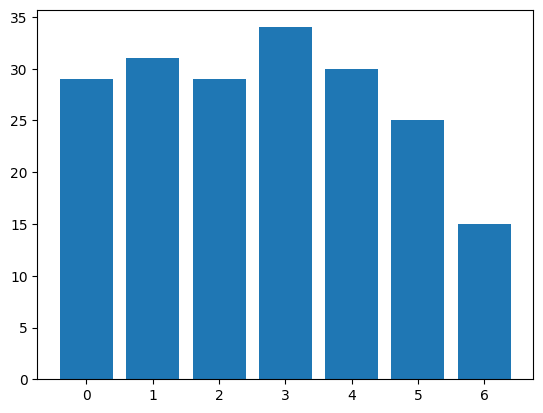

In [204]:
# Creating histogram
plt.bar(fraud_per_weekday['TransactionWeekDay'], fraud_per_weekday['FraudResult'])
 
# Show plot
plt.show()

In the plot above, we can see that there is no day more likely to get a fraudulent transaction. 

A fraud can happen any day of the week. Given that, I will not use `TransactionWeekDay` in my model, because it didn't give me any useful information.

### Fraud frequency per month

We will know plot the fraud frequency regarding the month.

In [205]:
# Create DataFram with the month and fraud
fraud_month = pd.DataFrame({
    'TransactionMonth': transaction_start_time_details['TransactionMonth'],
    'FraudResult': training_data['FraudResult'],
})

# Group the dataframe by month
fraud_per_month = fraud_month.groupby('TransactionMonth').sum()
fraud_per_month.reset_index(inplace=True)

fraud_per_month.head()

,TransactionMonth,FraudResult
0,1,64
1,2,53
2,11,14
3,12,62


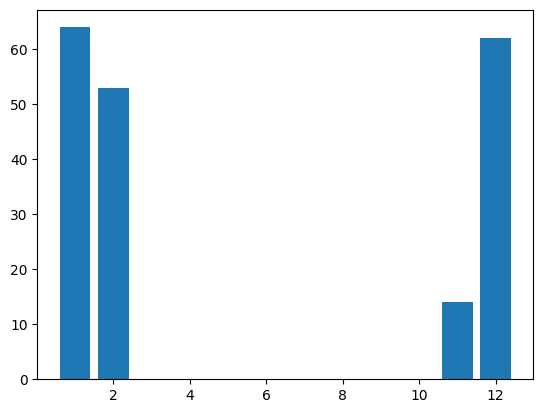

In [206]:
# Creating bar graph
plt.bar(fraud_per_month['TransactionMonth'], fraud_per_month['FraudResult'])
 
# Show plot
plt.show()

As we can see, there is a periodical pattern. The fraud generally happens between November to February.

We can then use this feature in our model.

### Fraud frequency per hour

We will analyse the frequency of the fraud regarding the hour of the day.

In [207]:
# Create DataFram with the month and fraud
fraud_hour = pd.DataFrame({
    'TransactionHour': transaction_start_time_details['TransactionHour'],
    'FraudResult': training_data['FraudResult'],
})

# Group the dataframe by month
fraud_per_hour = fraud_hour.groupby('TransactionHour').sum()
fraud_per_hour.reset_index(inplace=True)

fraud_per_hour.head(10)

,TransactionHour,FraudResult
0,0,1
1,1,0
2,2,0
3,3,7
4,4,0
5,5,6
6,6,7
7,7,9
8,8,8
9,9,10


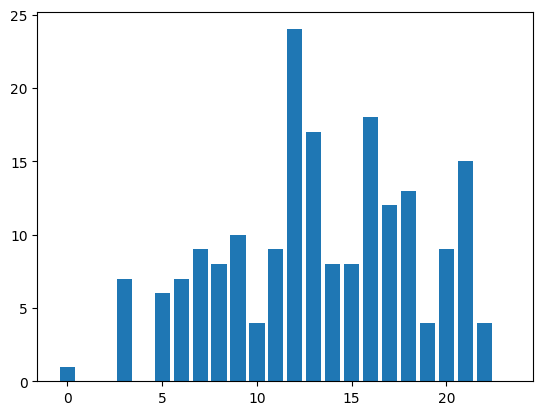

In [208]:
# Creating bar graph
plt.bar(fraud_per_hour['TransactionHour'], fraud_per_hour['FraudResult'])
 
# Show plot
plt.show()

In the case of the hour, we can see distinct groups. Some hours are more subject to fraud than others.

To reduce the dimensionality in our final data, we can cluster the `TransactionHour` using `K-means clustering`.

In [209]:
from sklearn.cluster import KMeans

def kmeansFraudHour(destination, clusters=3):
    # Create KMeans instance
    kmeans = KMeans(n_clusters=clusters)

    # Get the cluster result
    destination['TransactionHourCluster'] = kmeans.fit_predict(destination.loc[:, ['FraudResult']])
    destination['TransactionHourCluster'] = destination['TransactionHourCluster'].astype('category')

    return destination

In [210]:
fraud_per_hour = kmeansFraudHour(fraud_per_hour)
fraud_per_hour.groupby('TransactionHourCluster').head()

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,TransactionHour,FraudResult,TransactionHourCluster
0,0,1,1
1,1,0,1
2,2,0,1
3,3,7,0
4,4,0,1
5,5,6,0
6,6,7,0
7,7,9,0
8,8,8,0
10,10,4,1


<Axes: xlabel='TransactionHour', ylabel='FraudResult'>

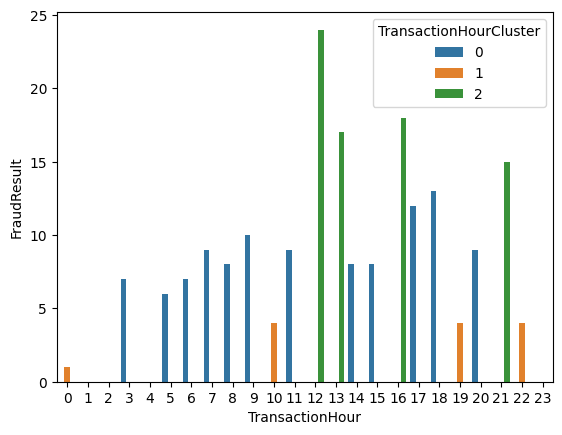

In [211]:
# Creating bar graph
sns.barplot(data=fraud_per_hour, x="TransactionHour", y="FraudResult", hue="TransactionHourCluster")

In our dataset, we will replace every our of `TransactionHour` by its cluster.

In [212]:
cluster_hour = {}
fraud_dict = fraud_per_hour.groupby(['TransactionHourCluster'])['TransactionHour'].apply(set).to_dict()

for cluster, hours in fraud_dict.items():
    for hour in hours:
        cluster_hour[hour] = cluster

print(cluster_hour)

{3: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 11: 0, 14: 0, 15: 0, 17: 0, 18: 0, 20: 0, 0: 1, 1: 1, 2: 1, 4: 1, 10: 1, 19: 1, 22: 1, 23: 1, 16: 2, 21: 2, 12: 2, 13: 2}


In [213]:
def apply_cluster_hour(destination):
    global cluster_hour

    # Replace every hour by its cluster
    destination = destination.replace({'TransactionHour': cluster_hour})

    return destination

In [214]:
# fraud_hour = encode_hour(fraud_hour)
fraud_hour = apply_cluster_hour(fraud_hour)
fraud_hour.head()

,TransactionHour,FraudResult
TransactionId,,
TransactionId_76871,1,0
TransactionId_73770,1,0
TransactionId_26203,1,0
TransactionId_380,0,0
TransactionId_28195,0,0


We have hardly reduced the numbers of distinct categories in our hours by applying a cluster to them.

### Resume

We have analysed the periodicity of a fraud violation over the time. We saw that a fraud happens on specific periods of the year. We can also see that you have some hours that are more subject to fraud.

In our dataset, we will add the following columns:

 * `TransactionMonth`: Month of the transaction. I will use a One-Hot Encoder.
 * `TransactionHour`: Replace the hour by its cluster, and then apply a One-Hot Encoder.

## Way to pay

For the next analysis, we will look at `Amount`. In the variable description, it says that the positive values refer to debit and negative to credit.

Given that information, we can analyse if a debit or credit payment affects the fraud violation.

The first step will be to extract this information, we will then create a column name `PaymentWay`.

 * **PaymentWay**: Debit or Credit

> Note: I will replace "debit" and "credit" by a One-Hot encoding

In [215]:
def apply_payment_way(destination):
    # Get the payment information
    destination['PaymentWay'] = np.where(destination['Amount'] > 0, 'debit', 'credit')

    # Remove the Amount columns
    destination.drop(columns=['Amount'], inplace=True)

    return destination

In [216]:
# Create an empty DataFrame
payment_information = training_data.loc[:, ['Amount']].copy()

# Apply the payment way function
payment_information = apply_payment_way(payment_information)

payment_information.head()

,PaymentWay
TransactionId,
TransactionId_76871,debit
TransactionId_73770,credit
TransactionId_26203,debit
TransactionId_380,debit
TransactionId_28195,credit


Now that we extracted the payment way from `Amount`, let's analyse if there is one way that is more subject to fraud than the other.

### Fraud frequency per Payment Way

We will analyse the fraud frequency regarding the payment method used: Debit or Credit.

In [217]:
# Create DataFram with the month and fraud
fraud_payment_way = pd.DataFrame({
    'PaymentWay': payment_information['PaymentWay'],
    'FraudResult': training_data['FraudResult'],
})


# Group the dataframe by month
fraud_per_payment_way = fraud_payment_way.groupby('PaymentWay').sum()
fraud_per_payment_way.reset_index(inplace=True)

fraud_per_payment_way.head(10)

,PaymentWay,FraudResult
0,credit,5
1,debit,188


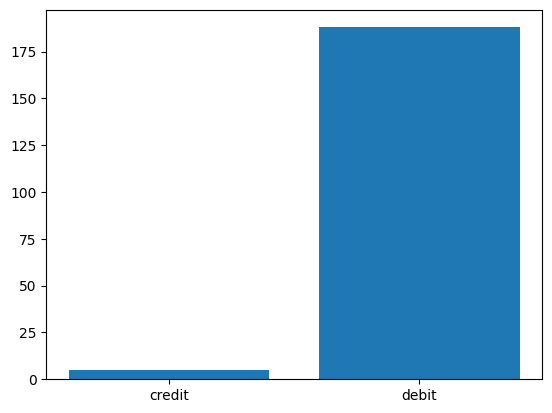

In [218]:
# Creating bar graph
plt.bar(fraud_per_payment_way['PaymentWay'], fraud_per_payment_way['FraudResult'])
 
# Show plot
plt.show()

As we can see on the chart above, there is a lot more fraud by debit than credit. We can then use this categorical variable during our training phase.

### Resume

We extracted the payment information and put it in `PaymentWay`. We have seen that you get more fraud violation with debit than credit. We can then classify them using a One-Hot Encoder.

## Pricing strategy

Let's analyse the pricing strategy and its influence on the fraud detection.

In [219]:
# Retrieve the pricing strategy
pricing_strategy = training_data.loc[:, ['PricingStrategy', 'FraudResult']]

# Check the number of fraud per princing strategy
fraud_per_pricing_strategy = pricing_strategy.groupby('PricingStrategy').sum()
fraud_per_pricing_strategy.reset_index(inplace=True)

fraud_per_pricing_strategy.head()

,PricingStrategy,FraudResult
0,0,36
1,1,7
2,2,139
3,4,11


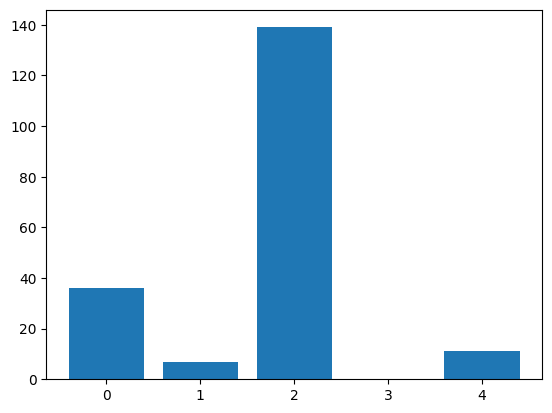

In [220]:
# Creating bar graph
plt.bar(fraud_per_pricing_strategy['PricingStrategy'], fraud_per_pricing_strategy['FraudResult'])
 
# Show plot
plt.show()

### Resume

As we can see, you have some `PricingStrategy` that gets more fraud violation, for instance `2` has a lot more fraud violation than the others. We can categorise it using a One-Hot Encoder.

# Value per Customer

A fraud violation can be affected by a customer, but as I said before, I don't want to categorise a fraud based on a customer or account. But we can extract the total amount of money that a customer has spent in our training phase.

I will check the total amount of value spend in non-fraud and fraud transaction and compare them.

In [221]:
# Fraud values
fraud_values = training_data[training_data['FraudResult'] == 1].groupby('CustomerId')[['Value']].sum()
fraud_values_mean = fraud_values['Value'].mean()

# Non fraud values
non_fraud_values = training_data[training_data['FraudResult'] == 0].groupby('CustomerId')[['Value']].sum()
non_fraud_values_mean = non_fraud_values['Value'].mean()

print(f'Mean of the sum of the values in fraudulant transaction: {fraud_values_mean}')
print(f'Mean of the sum of the values in non-fraudulant transaction: {non_fraud_values_mean}')

Mean of the sum of the values in fraudulant transaction: 5582058.722222222
Mean of the sum of the values in non-fraudulant transaction: 173057.7566336103


As we can see, the sum of the fraudulent transaction is almost 5 times bigger than the non-fraudulent transaction. We can assume that the sum of the value of every customer has a high impact on the fraud violation.

In [222]:
def get_value_per_customer(destination):
    # Get sum of each value for every customer
    customer_id_value = destination.groupby(['CustomerId'])[['Value']].sum().reset_index()

    # Add the customer total value in the destination
    for row in customer_id_value.to_dict('records'):
        destination.loc[destination['CustomerId'] == row['CustomerId'], 'ValuePerCustomer'] = row['Value']

    return destination

In [223]:
training_data_copy = get_value_per_customer(training_data.copy())

training_data_copy[['ValuePerCustomer']].head(10)

,ValuePerCustomer
TransactionId,
TransactionId_76871,203847.0
TransactionId_73770,203847.0
TransactionId_26203,1000.0
TransactionId_380,286623.0
TransactionId_28195,286623.0
TransactionId_23223,2000.0
TransactionId_118063,129800.0
TransactionId_100640,129800.0
TransactionId_51905,8340.0


### Resume

I will use the feature `ValuePerCustomer` in the training dataset.

## Channel ID

We will evaluate the effect of `ChannelId` over the fraud violation.

Same as before, let's check how much fraud there is for each channel.

In [224]:
# Retrieve the pricing strategy
channel_id = training_data.loc[:, ['ChannelId', 'FraudResult']]

# Check the number of fraud per princing strategy
fraud_per_channel_id = channel_id.groupby('ChannelId').sum()
fraud_per_channel_id.reset_index(inplace=True)

fraud_per_channel_id.head()

,ChannelId,FraudResult
0,ChannelId_1,4
1,ChannelId_2,5
2,ChannelId_3,184
3,ChannelId_5,0


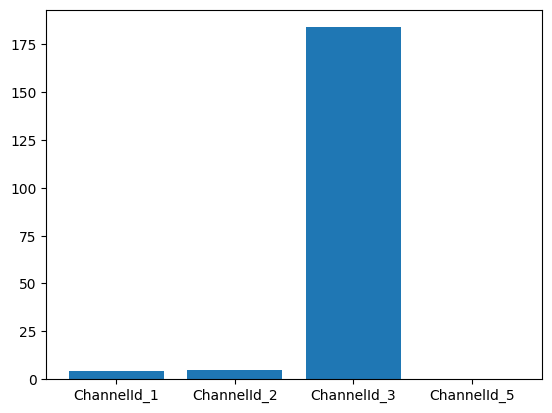

In [225]:
# Creating bar graph
plt.bar(fraud_per_channel_id['ChannelId'], fraud_per_channel_id['FraudResult'])
 
# Show plot
plt.show()

As we can see, `ChannelId_3` has more influence than the other one. Given that, we know that the `ChannelId` is a relevant feature of our model.

### Resume

`ChannelId` is a categorical variable that we can use in our dataset. I will apply a One-Hot encoding on this feature.

## Conclusion

At the end of our journey, we have a dataset with the following columns:

 * `TransactionId`
 * `Value`
 * `ValuePerCustomer`
 * `ChannelId`: One-Hot Encoded
 * `PaymentWay`: One-Hot Encoded
 * `PricingStrategy`: One-Hot Encoded
 * `TransactionMonth`: One-Hot Encoded
 * `ProductCategory`: One-Hot Encoded


## Categorise the data

To categorise our data, I will use a One-Hot encoder, because it is more efficient than an Ordinal encoder and works pretty well with a `RandomForest`.

As a reminder, a One-Hot Encoder will create new binary columns, indicating the presence of each possible value of the original data.

![One-Hot Encoding](./pictures/one-hot-encoding.png)


# Unbalanced dataset

To go further in our analysis, we will look at the proportion of fraudulent and non-fraudulent transactions in our dataset.

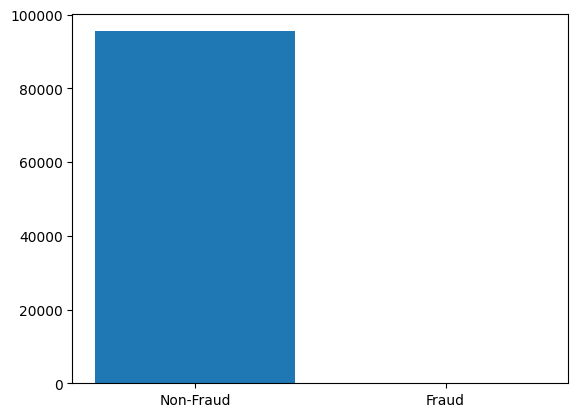

Fraud percentage: 0.20175200183981098


In [226]:
# Get FraudResult
fraud_result = training_data[['FraudResult']].copy()

# Count the occurence of every value
fraud_counts = fraud_result.value_counts()

# Creating bar graph
plt.bar(['Non-Fraud', 'Fraud'], fraud_counts)
 
# Show plot
plt.show()

# Compute the percentage value of fraud
fraud_percentage = (training_data['FraudResult'].sum() / len(training_data['FraudResult'])) * 100.0

print(f'Fraud percentage: {fraud_percentage}')

As we can see, only 0.2% of our data are a fraud. We are in frount of an **unbalanced dataset**.

Having an unbalanced dataset causes a model that will be biased, as it will perform well with the majority class and poorly with the minority.

In [227]:
cols_to_use = ['Amount', 'Value', 'PricingStrategy']

# Extract information from dataset
X_unbalanced = training_data[cols_to_use].copy()
y_unbalanced = training_data['FraudResult'].copy()

## Solution

The solution is to oversample. The purpose is to create some new false rows in our dataset to make it more balanced. The new row will be generated regarding the other ones.

We will use the function `SMOTE` that will generate our new rows.

For the sake of the illustration, I will remove the string columns from the dataset.

In [228]:
from imblearn.over_sampling import SMOTE

# Declare our oversampler
oversampler = SMOTE(random_state=0, sampling_strategy=0.5)

# Fit and oversample our data
X_oversampled, y_oversampled = oversampler.fit_resample(X_unbalanced, y_unbalanced)

# Rebuild the dataset
oversampled_dataset = pd.concat([X_oversampled, y_oversampled], axis=1)
oversampled_dataset.head()

,Amount,Value,PricingStrategy,FraudResult
0,1000.0,1000,2,0
1,-20.0,20,2,0
2,500.0,500,2,0
3,20000.0,21800,2,0
4,-644.0,644,2,0


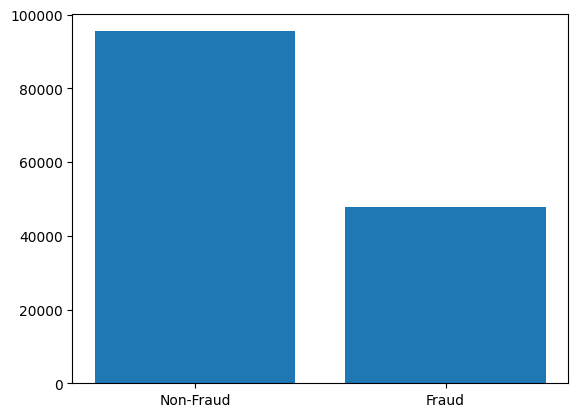

Fraud percentage: 33.33310056353568


In [229]:
# Get FraudResult
fraud_result = oversampled_dataset[['FraudResult']].copy()

# Count the occurence of every value
fraud_counts = fraud_result.value_counts()

# Creating bar graph
plt.bar(['Non-Fraud', 'Fraud'], fraud_counts)
 
# Show plot
plt.show()

# Compute the percentage value of fraud
fraud_percentage = (oversampled_dataset['FraudResult'].sum() / len(oversampled_dataset)) * 100.0

print(f'Fraud percentage: {fraud_percentage}')

Now our dataset is balanced and we can start the training of our model.

Oversampling a dataset allows to rebalance it. However, if we oversample, we may cause overfitting on the minority class which will lead to bad results on new data. This can also cause data leakage because it is possible that one of our rows is actually in the validation set.

# Set our data for the model

The analysis being finished, we can now predict our model. But first, we have to apply our features engineering on our training set.

In [230]:
COLS_TO_USE = ['Amount', 'TransactionStartTime', 'ProductCategory', 'ChannelId', 'Value', 'PricingStrategy', 'CustomerId', 'ProviderId']

def prepare_dataset(data_source):
    dataset = data_source[COLS_TO_USE].copy()

    # Apply data transformation
    dataset = get_value_per_customer(dataset)
    dataset = apply_payment_way(dataset)
    dataset = apply_transaction_start_date(dataset)
    dataset = apply_cluster_hour(dataset)

    # Drop useless features
    dataset.drop(columns=['CustomerId', 'ProviderId', 'TransactionWeekDay'], inplace=True)

    return dataset

In [231]:
from sklearn.model_selection import train_test_split

# Category where apply a One-Hot encoding
categorical_cols = ['PaymentWay', 'PricingStrategy', 'TransactionMonth', 'TransactionHour', 'ProductCategory', 'ChannelId']


# Check my dataset
X = prepare_dataset(training_data)
y = training_data['FraudResult']

# Apply One-Hot encoding
X = pd.get_dummies(data=X, columns=categorical_cols)

# Stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0, stratify=y)

In [232]:
X_train.head()

,Value,ValuePerCustomer,PaymentWay_credit,PaymentWay_debit,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4,TransactionMonth_1,TransactionMonth_2,...,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,ChannelId_ChannelId_1,ChannelId_ChannelId_2,ChannelId_ChannelId_3,ChannelId_ChannelId_5
TransactionId,,,,,,,,,,,,,,,,,,,,,
TransactionId_10839,50,105820.0,True,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,True,False,False
TransactionId_115893,20000,40000.0,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
TransactionId_28380,392,171434.0,True,False,False,False,True,False,False,True,...,False,False,False,False,False,False,False,True,False,False
TransactionId_114004,500,1510.0,False,True,False,False,False,True,True,False,...,False,False,False,False,False,False,True,False,False,False
TransactionId_3471,50,1171282.0,True,False,False,False,True,False,False,True,...,False,False,False,False,False,False,False,True,False,False


In [233]:
y_train.head()

TransactionId
TransactionId_10839     0
TransactionId_115893    0
TransactionId_28380     0
TransactionId_114004    0
TransactionId_3471      0
Name: FraudResult, dtype: int64

# Create the model

Now that our data is ready to be computed, let's define our model.

Here, we will make the comparison between 3 models:

 * **DecisionTreeClassifier**
 * **RandomForestClassifier**
 * **GradientBoostingClassifier**

For each model, we will optimize its hyperparameters using `GridSearchCV`.

# DecisionTreeClassifier

 It is a tree-like model that predicts the value of a target variable based on a set of input features.

In [234]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

parameters = {
    "max_depth": [10, 20, 30, 40, 50, 60, 70],
}

grid_search_dtc = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid = parameters , scoring = 'f1', cv = 3, n_jobs = 2,)
grid_scores_dtc = grid_search_dtc.fit(X_train , y_train)

In [235]:
print(grid_search_dtc.best_estimator_)
print(grid_search_dtc.best_score_)
print(grid_search_dtc.best_params_)

DecisionTreeClassifier(max_depth=10, random_state=0)
0.8937477555124613
{'max_depth': 10}


## RandomForestClassifier

It is based on the concept of decision trees and combines multiple decision trees to make more accurate predictions.

In [237]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {
    "n_estimators": [10, 50, 100, 150],
    "max_depth": [10, 20, 30, 40, 50],
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=0), param_grid = parameters , scoring = 'f1', cv = 5, n_jobs = 2,)
grid_scores_rf = grid_search_rf.fit(X_train , y_train)

In [238]:
print(grid_scores_rf.best_estimator_)
print(grid_scores_rf.best_score_)
print(grid_scores_rf.best_params_)

RandomForestClassifier(max_depth=20, n_estimators=50, random_state=0)
0.8507031112286269
{'max_depth': 20, 'n_estimators': 50}


# GradientBoostingClassifier

Gradient boosting is an iterative technique that tries to minimize the loss function by adding a new model at each iteration that predicts the residual errors of the previous model. 

In [252]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


parameters = {
    "n_estimators": [50, 100, 150],
    "max_depth": [20, 30, 40],
    "learning_rate": [0.01, 0.1, 0.2]
}

grid_search_gbc = GridSearchCV(GradientBoostingClassifier(random_state=0), param_grid = parameters , scoring = 'f1', cv = 3, n_jobs = 2,)
grid_scores_gbc = grid_search_gbc.fit(X_train , y_train)

In [253]:
print(grid_search_gbc.best_estimator_)
print(grid_search_gbc.best_score_)
print(grid_search_gbc.best_params_)

GradientBoostingClassifier(learning_rate=0.01, max_depth=20, n_estimators=50,
                           random_state=0)
0.9048081278716108
{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 50}


## Model

For the model, I choose to use the RandomForestClassifier because it is better suited for categorical data than the two others.

In [245]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


pipeline = Pipeline([
    ('smote', SMOTE(random_state=0, sampling_strategy=0.25)),
    ('model', grid_search_rf.best_estimator_),
])


## Train the model

We train our model with the training dataset.

In [246]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=0, sampling_strategy=0.25)),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=50,
                                        random_state=0))])

## Validation

We validate our model by comparing our data with the validation set. We calculate the `f1 score` to have an idea of the accuracy of our model

> Note: We use `f1 score` because it is suited for binary classification

We check the model prediction score. We take `F1 score` because it reflect a score for binary classification.

In [247]:
from sklearn.metrics import f1_score

preds = pipeline.predict(X_test)

print(f1_score(y_test, preds))

0.8


# Test dataset

Now that we have our model, we can predict the `FraudResult` of the test dataset ad submit it to [Xente](https://zindi.africa/competitions/xente-fraud-detection-challenge/submissions).

We first load the data from [test.csv](./data/test.csv) and prepare the dataset.

In [248]:
# Path to the test data
test_data_path = './data/test.csv'

# Load test data
test_data = pd.read_csv(test_data_path)

# Set TransactionId as index
test_data.set_index('TransactionId', inplace=True)

# Get the target
X_valid = prepare_dataset(test_data.copy())

# Apply One-Hot encoding
X_valid = pd.get_dummies(data=X_valid, columns=categorical_cols)

# Remove the columns that are not in the training dataset
X_valid.drop(columns=[col for col in X_valid.columns if col not in X_train.columns], inplace=True)

# Add the columns that are missing from the training set
for col in X_train.columns:
    if col not in X_valid.columns:
      X_valid.insert(X_valid.shape[1], col, pd.Series([0] * X_valid.shape[0]))
      X_valid[col].fillna(0, inplace=True)

# Set the same column order that in our training set
X_valid = X_valid[X_train.columns]

X_valid.head()

,Value,ValuePerCustomer,PaymentWay_credit,PaymentWay_debit,PricingStrategy_0,PricingStrategy_1,PricingStrategy_2,PricingStrategy_4,TransactionMonth_1,TransactionMonth_2,...,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,ChannelId_ChannelId_1,ChannelId_ChannelId_2,ChannelId_ChannelId_3,ChannelId_ChannelId_5
TransactionId,,,,,,,,,,,,,,,,,,,,,
TransactionId_50600,1000,10500.0,False,True,False,False,False,True,0.0,True,...,False,0.0,False,False,False,False,False,False,True,False
TransactionId_95109,2000,1072725.0,False,True,False,False,True,False,0.0,True,...,False,0.0,False,False,False,False,False,False,True,False
TransactionId_47357,50,10500.0,True,False,False,False,True,False,0.0,True,...,False,0.0,False,False,False,False,False,True,False,False
TransactionId_28185,3000,53240.0,False,True,False,False,False,True,0.0,True,...,False,0.0,False,False,False,False,False,False,True,False
TransactionId_22140,60,53240.0,True,False,False,False,True,False,0.0,True,...,False,0.0,False,False,False,False,False,True,False,False


We make the prediction of the test dataset.

In [249]:
pred = pd.Series(pipeline.predict(X_valid))

pred.head()


0    0
1    0
2    0
3    0
4    0
dtype: int64

We load our result into the submission file [my_submission.csv]('./data/my_submission.csv').

In [250]:
# Path of the submission template file
sample_submission_path = './data/sample_submission.csv'

# Read data from file
sample_submission =  pd.read_csv(sample_submission_path)

# Add our result to the submission file
sample_submission['FraudResult'] = pred

# Write the result into our submission file
sample_submission.to_csv('./data/my_submission.csv', index=False)

# Result

Here is the result on Xente.

![](./pictures/xente-result-last.png)

For any reason, I have another result on my Windows laptop.

![](./pictures/xente-result-windows.png)